# Topic keywords

Check which words are typical for topic tweets in different time frames

In [126]:
import csv
import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
import sys
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer
from collections import Counter
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
DATADIR = "/home/erikt/projects/puregome/data/text/"
ID = "id_str"
REPLYID = "in_reply_to_status_id_str"
TEXT = "text"
TOKEN = "token"
USER = "user"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Count tweets with topic words

In [44]:
def countTweets(datePattern, query):
    count_query = 0
    count_all = 0
    fileList = sorted(os.listdir(DATADIR))
    for inFileName in fileList:
        if re.search(datePattern, inFileName):
            squeal(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            count_query += len(df[df[TEXT].str.contains(query, flags=re.IGNORECASE)])
            count_all += len(df)
    return(count_query, count_all)

In [45]:
FILEPATTERN = "20200522"

for query in "corona|covid".split():
    count_query, count_all = countTweets(FILEPATTERN,query)
    print(count_query, count_all, query)

20200522-23.out.gz
29868 599613 corona|covid


## Find other relevant words in topic tweets

In [30]:
import warnings
warnings.simplefilter("ignore")

In [15]:
df = pd.read_csv(DATADIR+"20201001-00.out.gz")

In [31]:
len(df[df["text"].str.contains("(regering|kabinet)")==False])

17518

In [85]:
AT = r"@"
HASH = r"#"

def get_tokens_of_matched_tweets(file_pattern, query, spy=True):
    file_list = sorted(os.listdir(DATADIR))
    match_tokens = {}
    non_match_tokens = {}
    for file_name in file_list:
        if re.search(file_pattern,file_name):
            if spy: squeal(file_name)
            df = pd.read_csv(DATADIR+file_name, index_col=ID)
            matching_rows = df[TEXT].str.contains(query, flags=re.IGNORECASE)
            df_match = df[matching_rows]
            df_non_match = df[matching_rows == False]
            text = ""
            for i in range(0, len(df_match)):
                text += " " + re.sub("\\\\n", " ", str(df_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items(): 
                if not token in match_tokens: match_tokens[token] = count
                else: match_tokens[token] += count
            text = ""
            for i in range(0, len(df_non_match)):
                text += " " + re.sub("\\\\n", " ", str(df_non_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items(): 
                if not token in non_match_tokens: non_match_tokens[token] = count
                else: non_match_tokens[token] += count
    return(match_tokens, non_match_tokens)


def getTokensOfMatchedTweets(filePattern,query):
    fileList = sorted(os.listdir(DATADIR))
    matchTokens = {}
    nonMatchTokens = {}
    for inFileName in fileList:
        if re.search(filePattern,inFileName):
            squeal(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            for i in range(0,len(df)):
                text = re.sub("\\\\n"," ",str(df.iloc[i][TEXT]))
                if re.search(query,text):
                    for token in TweetTokenizer().tokenize(text.lower()): 
                        if not token in matchTokens: matchTokens[token] = 0
                        matchTokens[token] += 1
                else:
                    for token in TweetTokenizer().tokenize(text.lower()): 
                        if not token in nonMatchTokens: nonMatchTokens[token] = 0
                        nonMatchTokens[token] += 1
    return(matchTokens,nonMatchTokens)


def readData(fileName):
    return(pd.read_csv(fileName,index_col=TOKEN).to_dict())

def writeData(data,fileName):
    pd.DataFrame(data).to_csv(fileName,index_label=TOKEN)
    
def findKeysStartingWithChar(data,char):
    keysStartingWithChar = []
    for key in data:
        try:
            if re.search(r"^"+char+r"\w",key):
                shortKey = key[1:]
                if shortKey in data: keysStartingWithChar.append(shortKey)
        except: pass
    return(keysStartingWithChar)

def combineKeysStartingWithChar(data,char,keysStartingWithChar):
    for key in keysStartingWithChar:
        data[key] += data[char+key]
        del(data[char+key])
    return(data)

def combineInitialHashAt(data):
    keysStartingWithHash = findKeysStartingWithChar(data,HASH)
    data = combineKeysStartingWithChar(data,HASH,keysStartingWithHash)
    keysStartingWithAt = findKeysStartingWithChar(data,AT)
    data = combineKeysStartingWithChar(data,AT,keysStartingWithAt)
    return(data)

In [52]:
NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

def dictBottomN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][-n:])

In [53]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

In [89]:
QUERY_DISTANCE= r"1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERY_TOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
QUERY_TOPIC_SMALL = "corona|covid"
QUERY_TRAVEL = "reis|reizen"
QUERY_WASH_HANDS = "hand.*was|was.*hand|pfizer|astra"
QUERY_VACCIN = "vaccin|inent|spuit|prik"

def show_top_tokens(file_pattern, query, n=200):
    queryTokens = {}
    nonQueryTokens = {}
    tscoresDataQuery = {}
    tscoresDataNonQuery = {}
    query_tokens, non_query_tokens = get_tokens_of_matched_tweets(file_pattern, query, spy=False)
    tscores_data_query = makeTscoreData(query_tokens)
    tscores_data_non_query = makeTscoreData(non_query_tokens)
    print(file_pattern, end=" ")
    for x in dictTopN(sortTscores(tscore.computeTscore(tscores_data_query, tscores_data_non_query)), n=n): 
        print(x[1], end=" ")
    print()

In [90]:
MONTH = "202012"

for day in range(1,32):
    show_top_tokens(MONTH+str(day).zfill(2), QUERY_TOPIC_SMALL)

20201201 corona covid #coronamaatregelen 19 + #corona - de coronavirus #covid19 #covid19nl #coronavirus coronacrisis sinds 7d nov cijfers maatregelen coronamaatregelen virus griep zweden #mondkapjesplicht regels in aantal 1 testen #femkehalsema vlgs https://t.co/yb4c1fi32a klachten weken waarschuwing sneu vaccin positief horeca coronavaccin overleden tijdens coronatijd @amsterdamnl tegen % test dagen hamilton gisteren vanaf meer dec 🟣 #coronavaccin door @edwinveldhuizen scholen 100.000 besmettingen laten getest eerlijk inwoners januari eerst ervoor patiënten daarbij hugo dragen verspreiding rivm huisarts 24 * pandemie ' 7 doden ggd #covid besmet verplicht ] coronaregels kabinet open [ #mondkapjes ziekenhuizen vaccineren minder coronabesmettingen ⤵ @hugodejonge #coronacrisis oversterfte waarom ivm ➘ ic ‘ #alleensamen lewis wereld 👇 🛑 overlijdens bron eerste #mondkapje update informatie afgezwakt https://t.co/insuzbqofg ondersterfte ongemakkelijke #hugodejongekanniks positieve @rivm vanw

In [93]:
top_tokens = {}
infile = open("202012-tokens.txt","r")
for line in infile:
    tokens = line.strip().split()
    date = tokens.pop(0)
    top_tokens[date] = tokens
infile.close()

In [99]:
top_tokens_freq = {}
for date in top_tokens:
    top_tokens_freq[int(date)] = {}
    for i in range(0,len(top_tokens[date])):
        token = top_tokens[date][i]
        if i < 10: top_tokens_freq[int(date)][token] = 3
        elif i < 100: top_tokens_freq[int(date)][token] = 2
        else: top_tokens_freq[int(date)][token] = 1

In [105]:
top_tokens_freq7 = {}
for date in top_tokens_freq:
     for d in range(date-3,date+4):
            if d in top_tokens_freq:
                for token in top_tokens_freq[date]:
                    if not token in top_tokens_freq7: top_tokens_freq7[token] = {d:top_tokens_freq[date][token]}
                    elif d not in top_tokens_freq7[token]: top_tokens_freq7[token][d] = top_tokens_freq[date][token]
                    else: top_tokens_freq7[token][d] += top_tokens_freq[date][token]

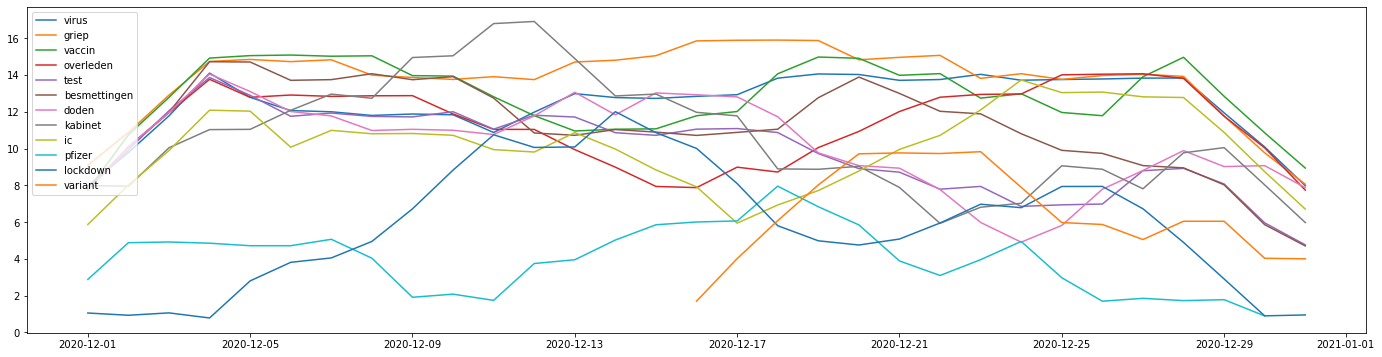

In [132]:
interesting_tokens = ["virus","griep","vaccin","overleden","besmettingen","doden","kabinet","ic","test","pfizer","lockdown","variant"]

plt.subplots(figsize=(24,6))
for token in top_tokens_freq7:
    if sum(top_tokens_freq7[token].values()) > 100 and token in interesting_tokens:
        plt.plot_date([datetime.datetime.strptime(str(d),"%Y%m%d") for d in top_tokens_freq7[token].keys()], 
                      [x-0.4*random.random()+0.1 for x in top_tokens_freq7[token].values()], fmt="-", label=token)
plt.legend(loc="upper left")
plt.show()

## Old code

In [ ]:
FILENAME202002 = "query-tokens-202002-202003.csv"
FILENAME202004 = "query-tokens-202004-202005.csv"
NON = "non-"
WEEKS = {"2020020[2-8]":"20200202","20200209|2020021[0-5]":"20200209","2020021[6-9]|2020022[0-2]":"20200216","2020022[3-9]":"20200223",\
         "2020030[1-7]":"20200301","2020030[89]|2020031[0-4]":"20200308","2020031[5-9]|2020032[01]":"20200315","2020032[2-8]":"20200322",\
                                   "20200329|20200330|2020040[1-4]":"20200329",\
         "2020040[5-9]|2020041[01]":"20200405","2020041[2-8]":"20200412","20200419|2020042[0-5]":"20200419","2020042[6-9]|2020043|2020050[1-2]":"20200426",\
         "2020050[3-9]":"20200503","2020051[0-6]":"20200510","2020051[7-9]|2020052[0-3]":"20200517"}

In [ ]:
queryTokens202002 = readData(FILENAME202004)
nonQueryTokens202002 = readData(NON+FILENAME202004)
tscoresDataQuery = {}
tscoresDataNonQuery = {}
tscores = {}
for query in queryTokens202002:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202002[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202002[query]))
    print(query)
    tscores[query] = sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))
    for x in dictTopN(tscores[query]): print(round(x[0],1),x[1])

In [ ]:
# writeData(tscores,"tscores-202004-202005.csv")

In [ ]:
tscores202002 = readData("tscores-202002-202003.csv")
tscores202004 = readData("tscores-202004-202005.csv")

In [ ]:
TOPICS = "maatregelen mondkapje anderhalve besmet rivm ".split()

data = {}
for topic in TOPICS:
    for date in tscores202002.keys():
        if not topic in data: data[topic] = {}
        data[topic][date] = tscores202002[date][topic]
    for date in tscores202004.keys():
        data[topic][date] = tscores202004[date][topic]

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

DATEFORMAT = "%Y%m%d"

fig,ax = plt.subplots(figsize=(8,4))
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
for topic in TOPICS:
    plt.plot_date([datetime.strptime(WEEKS[date],DATEFORMAT) for date in data[topic]],list(data[topic].values()),label=topic,fmt="-")
ax.set(xlabel="date (weeks)",ylabel="t-scores")
plt.title("t-scores for relevant words, comparing selected topic tweets with unselected tweets")
plt.legend()
plt.show()

**Note**: We expected only positive scores for topic words but the graph shows that *anderhalve* had negative scores  in two weeks. This means that most of the tweets containing this word are outside our topic tweets. We checked a sample of these missing tweets and most of them turned out to be on-topic, but they lacked the words *corona* and *covid*.

In [ ]:
data["anderhalve"]

In [ ]:
for date in tscores202002: 
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202002[date]),n=50): print(round(x[0],1),x[1])
for date in tscores202004:
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202004[date]),n=50): print(round(x[0],1),x[1])

In [ ]:
queryTokens202004 = readData(FILENAME202004)
nonQueryTokens202004 = readData(NON+FILENAME202004)
for query in queryTokens202004:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202004[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202004[query]))
    print(query)
    for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))): print(round(x[0],1),x[1])

In [ ]:
#writeData(queryTokens,"query-tokens-202004-202005.csv")
#writeData(nonQueryTokens,"non-query-tokens-202004-202005.csv")

In [ ]:
query = "2020051[7-9]|2020052[0-3]"
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query])),n=40): print(round(x[0],1),x[1])

In [ ]:
FILEPATTERN = "20200601" 
QUERY= r"1.5m|1,5m|afstand.*hou|hou.*afstand|anderhalve"

queryTokens = {}
nonQueryTokens = {}
tscoresDataQuery = {}
tscoresDataNonQuery = {}
queryTokens[FILEPATTERN],nonQueryTokens[FILEPATTERN] = getTokensOfMatchedTweets(FILEPATTERN,QUERY)
tscoresDataQuery[FILEPATTERN] = makeTscoreData(queryTokens[FILEPATTERN])
tscoresDataNonQuery[FILEPATTERN] = makeTscoreData(nonQueryTokens[FILEPATTERN])
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[FILEPATTERN],tscoresDataNonQuery[FILEPATTERN])),n=40): 
    print(round(x[0],1),x[1])

**Note**: the query "zorg" produces many false positives. There are irrelevant types ("bezorgd" and "bezorgen"), irrelevant syntactical forms ("ik zorg dat" and "Zorg dat je") and even the correct sense is not always related to the pandemic topic ("zorg voor ouderen/gehandicapten").

## Estimate coverage of crawler by looking back for messages with replies

In [ ]:
DATEPATTERN = "20200522"

fileList = sorted(os.listdir(DATADIR))
seenIds = {}
for inFileName in fileList:
    if re.search(DATEPATTERN,inFileName):
        df = pd.read_csv(DATADIR+inFileName,compression="gzip",dtype=str)
        known = 0
        unknown = 0
        for i in range(0,len(df)):
            idstr = df.iloc[i][ID]
            seenIds[idstr] = True
            replyParent = df.iloc[i][REPLYID]
            if str(replyParent) != "nan":
                if replyParent in seenIds: known += 1
                else: unknown += 1
        print("{0} {1:.3f}".format(inFileName,round(known/(known+unknown),3)))